In [1]:
# wspinaczka 2
import numpy as np
import pandas as pd
import os
from matplotlib.pyplot import plot


data_path = "dane/"

In [2]:
#data_path = "dane/"
df = pd.read_csv(os.path.join(data_path, "dane_spr1.csv"), sep=';')
#df = pd.read_excel(os.path.join(data_path, "dane1.xlsx"))

In [3]:
df_backup = df
df

,Zadanie,Czas wykonania,Termin
0,1,10,1746
1,2,10,2134
2,3,19,1339
3,4,17,1059
4,5,6,380
5,6,8,1820
6,7,16,196
7,8,19,575
8,9,2,619
9,10,16,1301


In [4]:
# KR to wartość naszego rozwiązania - ma być najmniejsza
def get_KR(df = df):
    c_sum = df["Czas wykonania"].cumsum() # suma kumultatywna kolumny "Czas wykonania"
    KR = (df["Termin"] - c_sum)**2 # obliczanie kwadratu różnicy wartosći
    return sum(KR) # KR jest wskaźnikiem jakości ułożenia zadań. To optymalizujemy

# wyszukiwanie listy sąsiadów
def get_neighbours(idx, neighbours_count = 10, df = df):
    N = neighbours_count
    # Idea sąsiedztwa dla N = 6 i idx = n E <N/2 ; L-N/2>
    # idx = X, sąsiad = 0, nie sąsiad = -
    # nr_indeksu | ... | n-4 | n-3 | n-2 | n-1 |  n  | n+1 | n+2 | n+3 | n+4 | ... |
    # sasiedztwo |  -  |  -  |  0  |  0  |  0  |  X  |  0  |  0  |  0  |  -  |  -  |
    
    L = len(df) - 1 
    idx_prev = idx # indeks dla ktorego szukamy sasiadow
    N_half = N//2 # polowa wartosci N
    
    
    # Idea sąsiedztwa dla N = 6 i idx = n < N/2
    # idx = X, sąsiad = 0, nie sąsiad = -
    # przykład n = 2
    # nr_indeksu |  0  |  1  | n=2 |  3  |  4  |  5  |  6  |  7  |  8  |  9  | ... |
    # sasiedztwo |  0  |  0  |  X  |  0  |  0  |  0  |  0  |  -  |  -  |  -  |  -  |
    # skoro nie mozemy znaleźć wystarczająco dużo sąsiadów po lewej, 
    # szukamy dodatkowego po prawej
    if idx < N_half:
        idx = N_half
    # idea sąsiedztwa z ograniczeniem z prawej jest analogiczna do tej z ograniczeniem z lewej
    elif idx > L - N_half:
        idx = L - N_half
    output = list(range(idx - N_half, idx + N_half + 1))
    # usuwanie idx z output
    # TODO: na pewno da się to zrobić prościej
    rm_idx = output.index(idx_prev)
    output = np.array(output)
    output = np.delete(output, rm_idx)
    return output

def calculate_improvements(KR_before, idx, neighbours, improvements, df = df):
    for neighbour, improvement in zip(
        neighbours, 
        np.nditer(improvements, op_flags = ['readwrite'])
    ):
        swap(idx, neighbour)
        improvement[...] = np.float64(get_KR() - KR_before)
        swap(idx, neighbour)
        
def search_for_the_best_neighbour(neighbours, improvements):
    if improvements.min() > 0:
        return False
    idx_min = improvements.argmin() # index najmniejszego elementu
    return neighbours[idx_min]

def swap(idx_1, idx_2, df=df):
    # zamiana miejscami dwóch wierszy "in place" - nie tworzymy nowej ramki danych
    df.iloc[idx_1], df.iloc[idx_2] = df.iloc[idx_2].copy(), df.iloc[idx_1].copy()
    
def move(idx_1, idx_2, df=df):
    swap(idx_1, idx_2) # ruch
    
def plot_optimalization(optimalization):
    # TODO: można to zrobić ładniej matplotlibem
    optimalization["Wartosc kombinacji"].plot(kind="line")

In [5]:
def hill_climbing_algorithm(
    number_of_iterations = 1000, 
    break_counter = 10, 
    neighbours_count = 20,
    starting_index = np.random.randint(len(df))
):
    KR_before = get_KR() # początkowa wartość kombinacji
    optimalization = pd.DataFrame(columns=["Wartosc kombinacji"])
    optimalization = optimalization.append({
                    "Wartosc kombinacji": KR_before
                }, ignore_index=True)
    improvements = np.zeros(neighbours_count)
    idx = starting_index
    
    while number_of_iterations and break_counter:
        neighbours = get_neighbours(idx, neighbours_count=neighbours_count) # lista sąsiadów
        # obliczanie potencjalnych ulepszeń dla sąsiadów
        calculate_improvements(KR_before, idx, neighbours, improvements)
        # wyszukanie sąsiada dla którego ulepszenie będzie największe
        best_neighbour = search_for_the_best_neighbour(neighbours, improvements)

        # jeżeli istnieje sąsiad po zamianie z którym ulepszymy kombinacje
        if best_neighbour:
            # zamiana miejscami z sąsiadem
            move(idx, best_neighbour)
            # obliczanie obecnej kombinacji
            KR_now = get_KR()
            # kolejna iteracja rozpoczyna się od miejsca na które wskoczył idx
            idx = best_neighbour  
            # dodawanie obecnej wartości kombinacji do listy wszystkich wartości
            optimalization = optimalization.append({
                "Wartosc kombinacji": KR_now
            }, ignore_index=True)
            
            KR_before = KR_now
            number_of_iterations -= 1
        else:
            break_counter -= 1
            
    order = df["Zadanie"]
    
    return order, optimalization

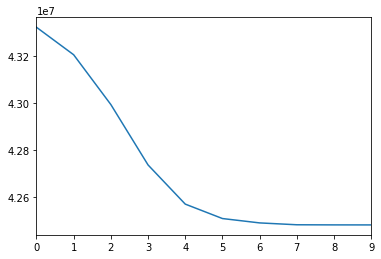

In [6]:
if __name__ == '__main__':
    
    # generowanie 50 elemntowej permutacji indeksów początkowych dla multistartu
    arr = np.arange(len(df))
    np.random.shuffle(arr)
    arr = arr.reshape((4, 50))
    arr = arr[0]
    starting_points = arr # 50 punktów startowych lista intów
    
    order = pd.DataFrame()
    value_of_order = np.inf
    
    for point in starting_points:
        new_order, new_optimalization = hill_climbing_algorithm(
                number_of_iterations=300,
                break_counter=20,
                neighbours_count=30,
                starting_index=point
            )
        new_value = new_optimalization["Wartosc kombinacji"].iloc[-1] # ostatnia wartość
        if new_value < value_of_order:
            order = new_order.copy()
            value_of_order = new_value
    
    
    plot_optimalization(new_optimalization)
    #new_optimalization["Wartosc kombinacji"].iloc[-1]
    

In [7]:

value_of_order

42483671

In [8]:
order

0        1
1       56
2      122
3       38
4       55
5       83
6        7
7      110
8       35
9       54
10      84
11      24
12      37
13      12
14     142
15      16
16      17
17     191
18       5
19      40
20      67
21     133
22       8
23     100
24      62
25      28
26      99
27      52
28      53
29      48
      ... 
170     89
171    199
172    145
173    155
174    106
175    129
176    153
177    197
178      2
179    167
180    117
181     29
182    149
183     95
184     69
185     66
186    158
187    116
188    193
189    120
190    169
191    123
192    185
193    151
194    182
195    138
196    126
197    156
198     91
199    165
Name: Zadanie, Length: 200, dtype: int64

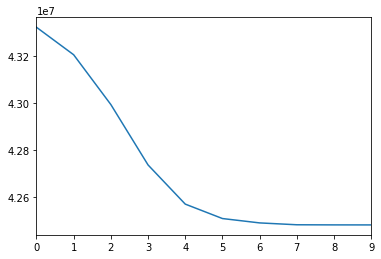

In [9]:
plot_optimalization(new_optimalization)

In [10]:
#df.to_csv("./wynik_multi_sprawko_50_50_20_20(NOWE).csv")